In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.trainers as tr
import src.read_pic as rp
import os
# Fields to read.
fields_to_read={"B":True,"B_ext":False,"divB":True,"E":True,"E_ext":False,"rho":True,"J":True,
                "P":True,"PI":False,"Heat_flux":False,"N":False,"Qrem":False}
# Path of the folder containing the .h5 files to read.
files_path="/volume1/scratch/share_dir/peppe/" #"/lustre1/project/stg_00032/share_dir/brecht/" # "/users/cpa/francesc/share_dir/SW/data_small/" #"/users/cpa/francesc/share_dir/jincai/dat_FF2D07e/" #="/users/cpa/francesc/share_dir/nn/data/raw_data/"
experiments = [f.name for f in os.scandir(files_path) if f.is_dir()]
print(f"{experiments = }")

experiments = ['data', 'data_filter']


In [2]:
experiment = 'data_filter'
data, X, Y, qom, times = rp.get_exp_times([experiment], files_path, fields_to_read, choose_species=[None,'i'], verbose=True)
data = data[experiment]

INFO:src.read_pic: reading /volume1/scratch/share_dir/peppe//data_filter/SimulationData.txt
INFO:src.read_pic:Lx = 64.0, Ly = 64.0, nxc = 512, nyc = 512
INFO:src.read_pic:loading B
INFO:src.read_pic:loading E
INFO:src.read_pic:loading divB
INFO:src.read_pic:loading rho
INFO:src.read_pic:loading J
INFO:src.read_pic:loading P and/or PI
INFO:src.read_pic:Component Pyx for species i missing because tensor is symmetric
INFO:src.read_pic:Component Pzx for species i missing because tensor is symmetric
INFO:src.read_pic:Component Pzy for species i missing because tensor is symmetric
INFO:src.read_pic:loading Ppar and Pperp
INFO:src.read_pic:choose_x = [0, 512], choose_y = [0, 512], choose_z = [0, 1], choose_times =None


In [3]:
data['Bx'].shape, X.shape

((512, 512, 31), (512, 512))

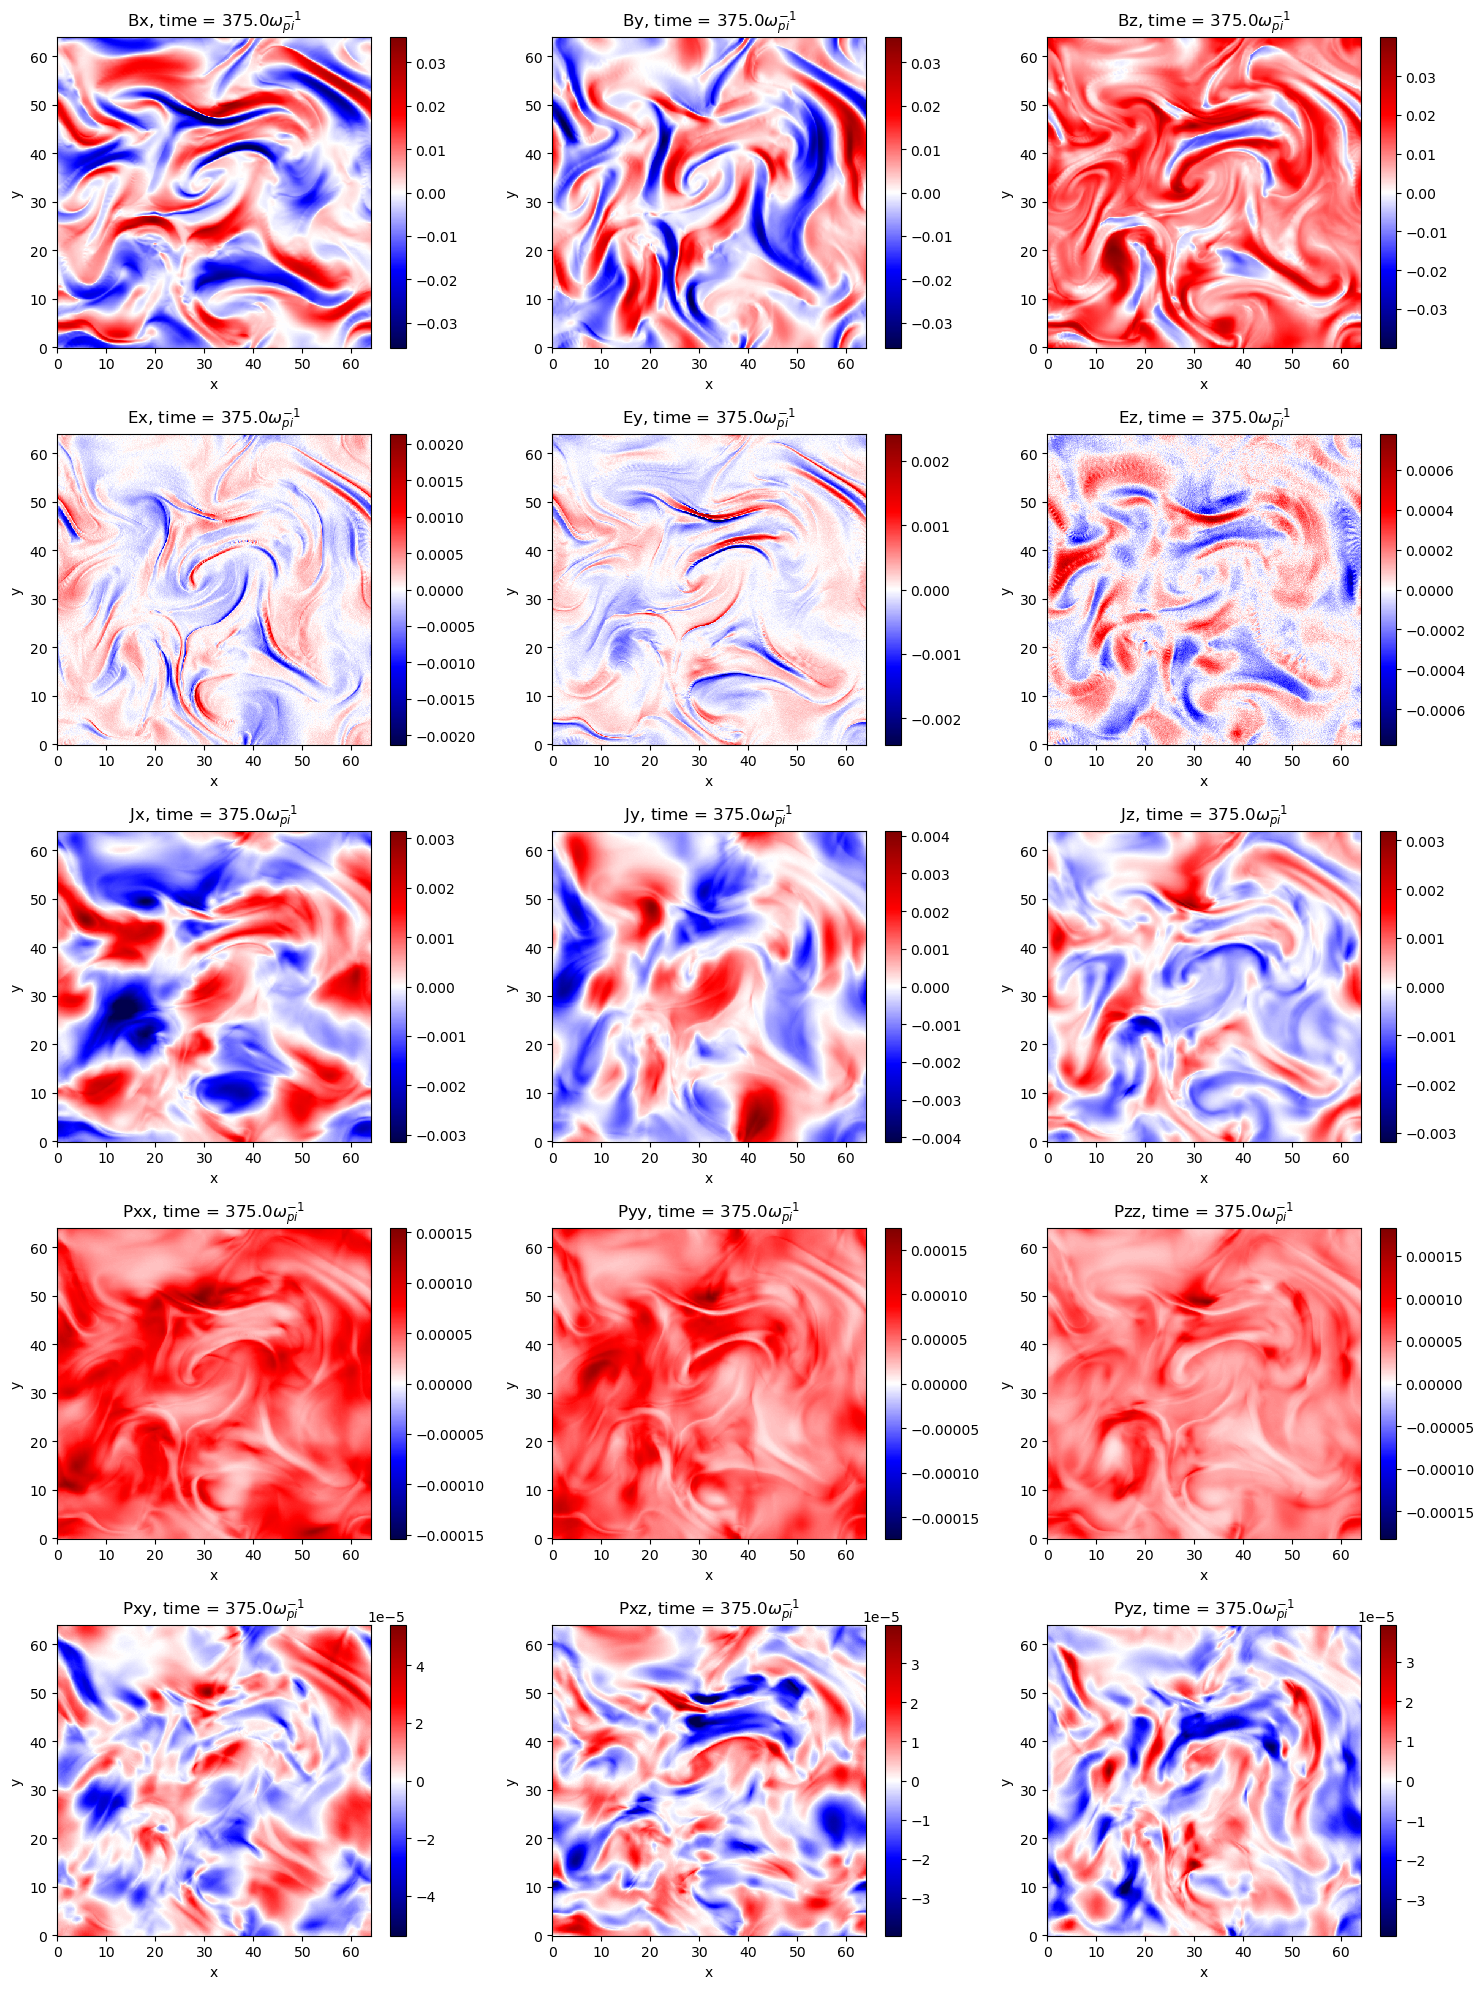

In [4]:
import numpy as  np
i = 15
time = times[i]
fig, axs = plt.subplots(5, 3, figsize=(15, 20))
fields = ['Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez', 'Jx', 'Jy', 'Jz', 'Pxx','Pyy','Pzz','Pxy','Pxz','Pyz']
for ax, field in zip(axs.flat, fields):
    if field in ['Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez']:
        im = ax.pcolormesh(X, Y, data[field][...,i], cmap='seismic', vmax = data[field][...,i].max(), vmin = -data[field][...,i].max())
    else:
        im = ax.pcolormesh(X, Y, data[field]['i'][...,i], cmap='seismic', vmax = data[field]['i'][...,i].max(), vmin = -data[field]['i'][...,i].max())
    fig.colorbar(im, ax=ax)
    ax.set_title(f"{field}, time = {time}"+r"$\omega_{pi}^{-1}$")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()
plt.show()

In [5]:
import numpy as  np
def field_aligned_trafo(Bx, By, Bz, to_transform, matrix = False): #if matrix: to_transform is nx3x3 matrix, else: nx3 component vector

    #normalization factors
    norm_epar_2 = 1e-10+Bx*Bx+By*By+Bz*Bz
    norm_eperp1_2 = 1e-10+Bx*Bx+By*By

    #unit vectors
    e_par_x = Bx/np.sqrt(norm_epar_2)
    e_par_y = By/np.sqrt(norm_epar_2)
    e_par_z = Bz/np.sqrt(norm_epar_2)

    e_perp1_x = By/np.sqrt(norm_eperp1_2)
    e_perp1_y = -Bx/np.sqrt(norm_eperp1_2)
    e_perp1_z = np.zeros(len(e_perp1_y))

    e_perp2_x = Bx*Bz/np.sqrt(norm_epar_2*norm_eperp1_2)
    e_perp2_y = Bz*By/np.sqrt(norm_epar_2*norm_eperp1_2)
    e_perp2_z = -(Bx*Bx+By*By)/np.sqrt(norm_epar_2*norm_eperp1_2)

    #construct the transformation matrix
    trafo_mat = np.zeros((len(e_par_x),3,3))

    trafo_mat[:,0,0] = e_par_x
    trafo_mat[:,0,1] = e_par_y
    trafo_mat[:,0,2] = e_par_z

    trafo_mat[:,1,0] = e_perp1_x
    trafo_mat[:,1,1] = e_perp1_y
    trafo_mat[:,1,2] = e_perp1_z

    trafo_mat[:,2,0] = e_perp2_x
    trafo_mat[:,2,1] = e_perp2_y
    trafo_mat[:,2,2] = e_perp2_z

    if matrix:
        #reshape the input matrix to be a stack of 3x3 matrices
        TT_xyz_3x3 = np.zeros((len(e_par_x),3,3))
        TT_xyz_3x3[:,0,0] = to_transform[0,:]
        TT_xyz_3x3[:,0,1] = to_transform[1,:]
        TT_xyz_3x3[:,0,2] = to_transform[2,:]

        TT_xyz_3x3[:,1,0] = to_transform[3,:]
        TT_xyz_3x3[:,1,1] = to_transform[4,:]
        TT_xyz_3x3[:,1,2] = to_transform[5,:]

        TT_xyz_3x3[:,2,0] = to_transform[6,:]
        TT_xyz_3x3[:,2,1] = to_transform[7,:]
        TT_xyz_3x3[:,2,2] = to_transform[8,:]

        #construct the transposed transformation matrix
        trafo_mat_transp = np.zeros((len(e_par_x),3,3))
        trafo_mat_transp[:,0,0] = e_par_x
        trafo_mat_transp[:,1,0] = e_par_y
        trafo_mat_transp[:,2,0] = e_par_z

        trafo_mat_transp[:,0,1] = e_perp1_x
        trafo_mat_transp[:,1,1] = e_perp1_y
        trafo_mat_transp[:,2,1] = e_perp1_z

        trafo_mat_transp[:,0,2] = e_perp2_x
        trafo_mat_transp[:,1,2] = e_perp2_y
        trafo_mat_transp[:,2,2] = e_perp2_z

        #transform the quantity
        trafo_quant = np.matmul(trafo_mat, TT_xyz_3x3)
        trafo_quant = np.matmul(trafo_quant, trafo_mat_transp)

    else:
        #transform the quantity
        trafo_quant = np.matmul(trafo_mat,to_transform)
    return(trafo_quant)



def transform_field(Bx, By, Bz, Fx, Fy, Fz):
    #print('transforming field')
    F_vec = np.zeros((len(Fx), 3, 1))
    F_vec[:,0] = np.reshape(Fx,(len(Fx),1))
    F_vec[:,1] = np.reshape(Fy,(len(Fy),1))
    F_vec[:,2] = np.reshape(Fz,(len(Fz),1))
    F_magn_arr = field_aligned_trafo(Bx,By,Bz, F_vec)
    F_magn = np.reshape(F_magn_arr, (len(Fx), 3))
    F_magn_par = F_magn[:,0]
    F_magn_per1 = F_magn[:,1]
    F_magn_per2 = F_magn[:,2]

    return F_magn_par, F_magn_per1, F_magn_per2

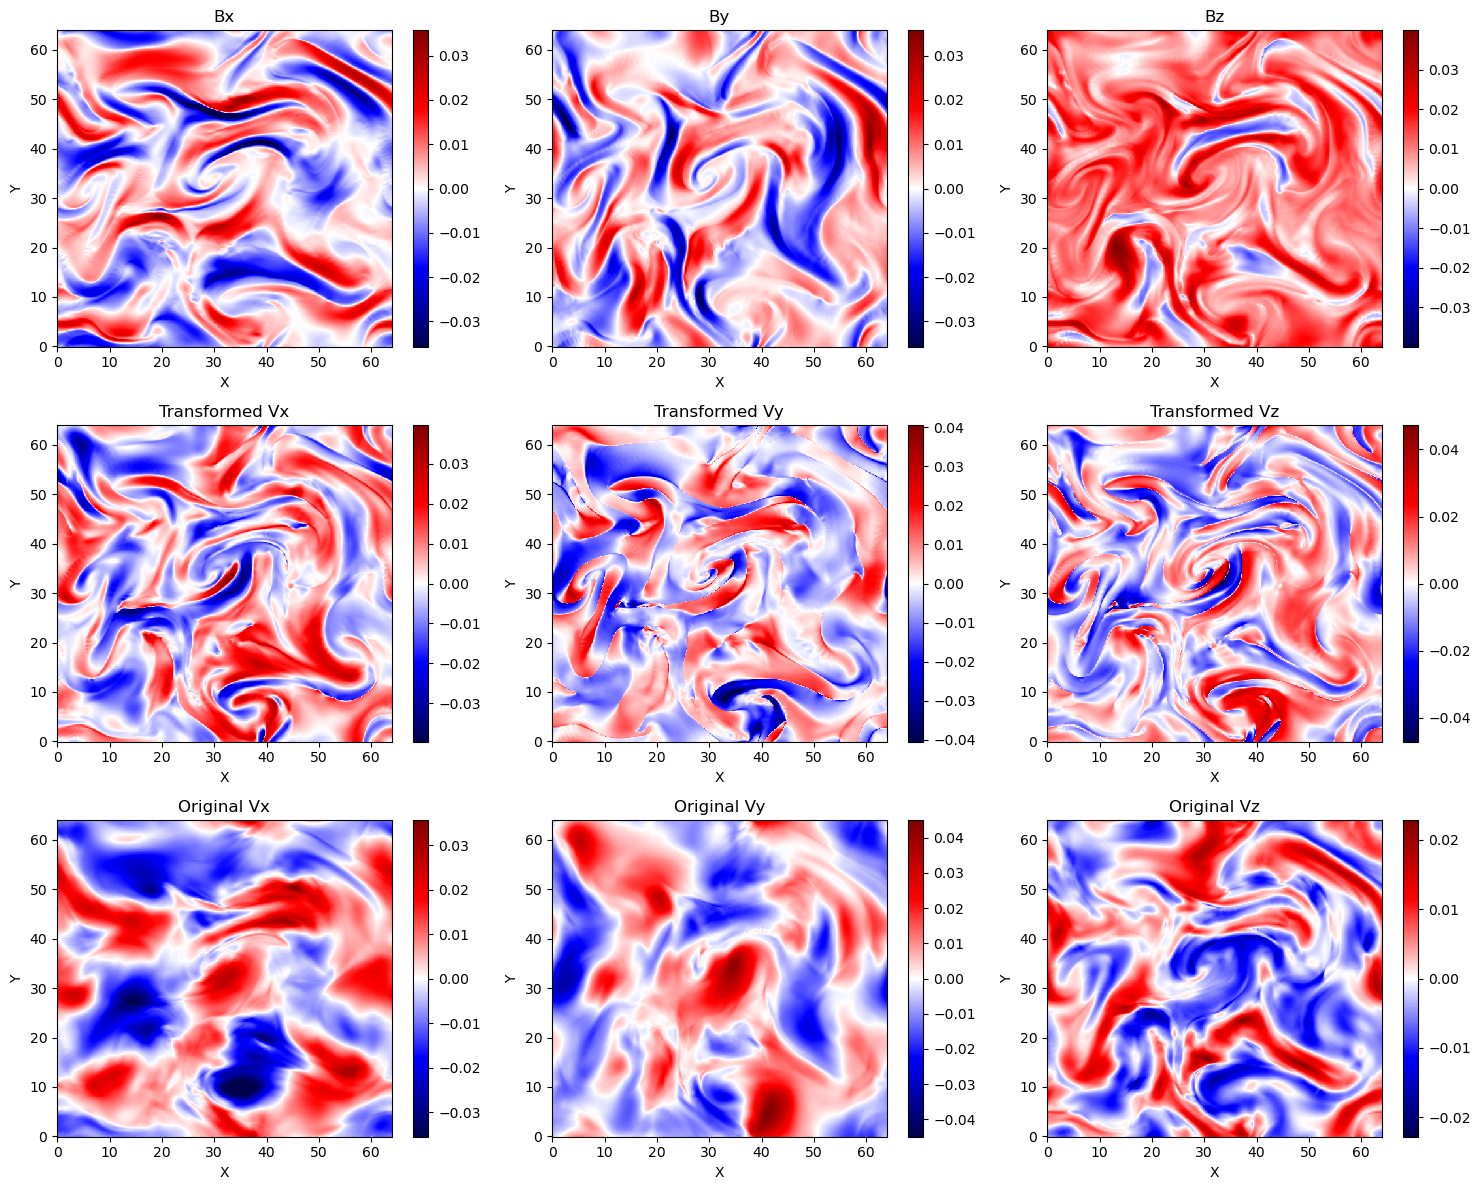

In [6]:
i = 15
Vx = data['Vx']['i'][...,i].flatten()
Vy = data['Vy']['i'][...,i].flatten()
Vz = data['Vz']['i'][...,i].flatten()
Bx = data['Bx'][...,i].flatten()
By = data['By'][...,i].flatten()
Bz = data['Bz'][...,i].flatten()
Vx, Vy, Vz = transform_field(Bx, By, Bz, Vx, Vy, Vz)
Vx = Vx.reshape(data['Vx']['i'][...,i].shape)
Vy = Vy.reshape(data['Vy']['i'][...,i].shape)
Vz = Vz.reshape(data['Vz']['i'][...,i].shape)
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
# Top panels: Bx, By, Bz
axs[0, 0].pcolormesh(X, Y, Bx.reshape(data['Bx'][...,i].shape), cmap='seismic', vmax=Bx.max(), vmin=-Bx.max())
axs[0, 0].set_title('Bx')
axs[0, 1].pcolormesh(X, Y, By.reshape(data['By'][...,i].shape), cmap='seismic', vmax=By.max(), vmin=-By.max())
axs[0, 1].set_title('By')
axs[0, 2].pcolormesh(X, Y, Bz.reshape(data['Bz'][...,i].shape), cmap='seismic', vmax=Bz.max(), vmin=-Bz.max())
axs[0, 2].set_title('Bz')

# Middle panels: Vx, Vy, Vz
axs[1, 0].pcolormesh(X, Y, Vx, cmap='seismic', vmax=Vx.max(), vmin=-Vx.max())
axs[1, 0].set_title('Transformed Vx')
axs[1, 1].pcolormesh(X, Y, Vy, cmap='seismic', vmax=Vy.max(), vmin=-Vy.max())
axs[1, 1].set_title('Transformed Vy')
axs[1, 2].pcolormesh(X, Y, Vz, cmap='seismic', vmax=Vz.max(), vmin=-Vz.max())
axs[1, 2].set_title('Transformed Vz')

# Bottom panels: Original Vx, Vy, Vz
axs[2, 0].pcolormesh(X, Y, data['Vx']['i'][...,i], cmap='seismic', vmax=data['Vx']['i'][...,i].max(), vmin=-data['Vx']['i'][...,i].max())
axs[2, 0].set_title('Original Vx')
axs[2, 1].pcolormesh(X, Y, data['Vy']['i'][...,i], cmap='seismic', vmax=data['Vy']['i'][...,i].max(), vmin=-data['Vy']['i'][...,i].max())
axs[2, 1].set_title('Original Vy')
axs[2, 2].pcolormesh(X, Y, data['Vz']['i'][...,i], cmap='seismic', vmax=data['Vz']['i'][...,i].max(), vmin=-data['Vz']['i'][...,i].max())
axs[2, 2].set_title('Original Vz')

for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(ax.collections[0], ax=ax)

plt.tight_layout()
plt.show()


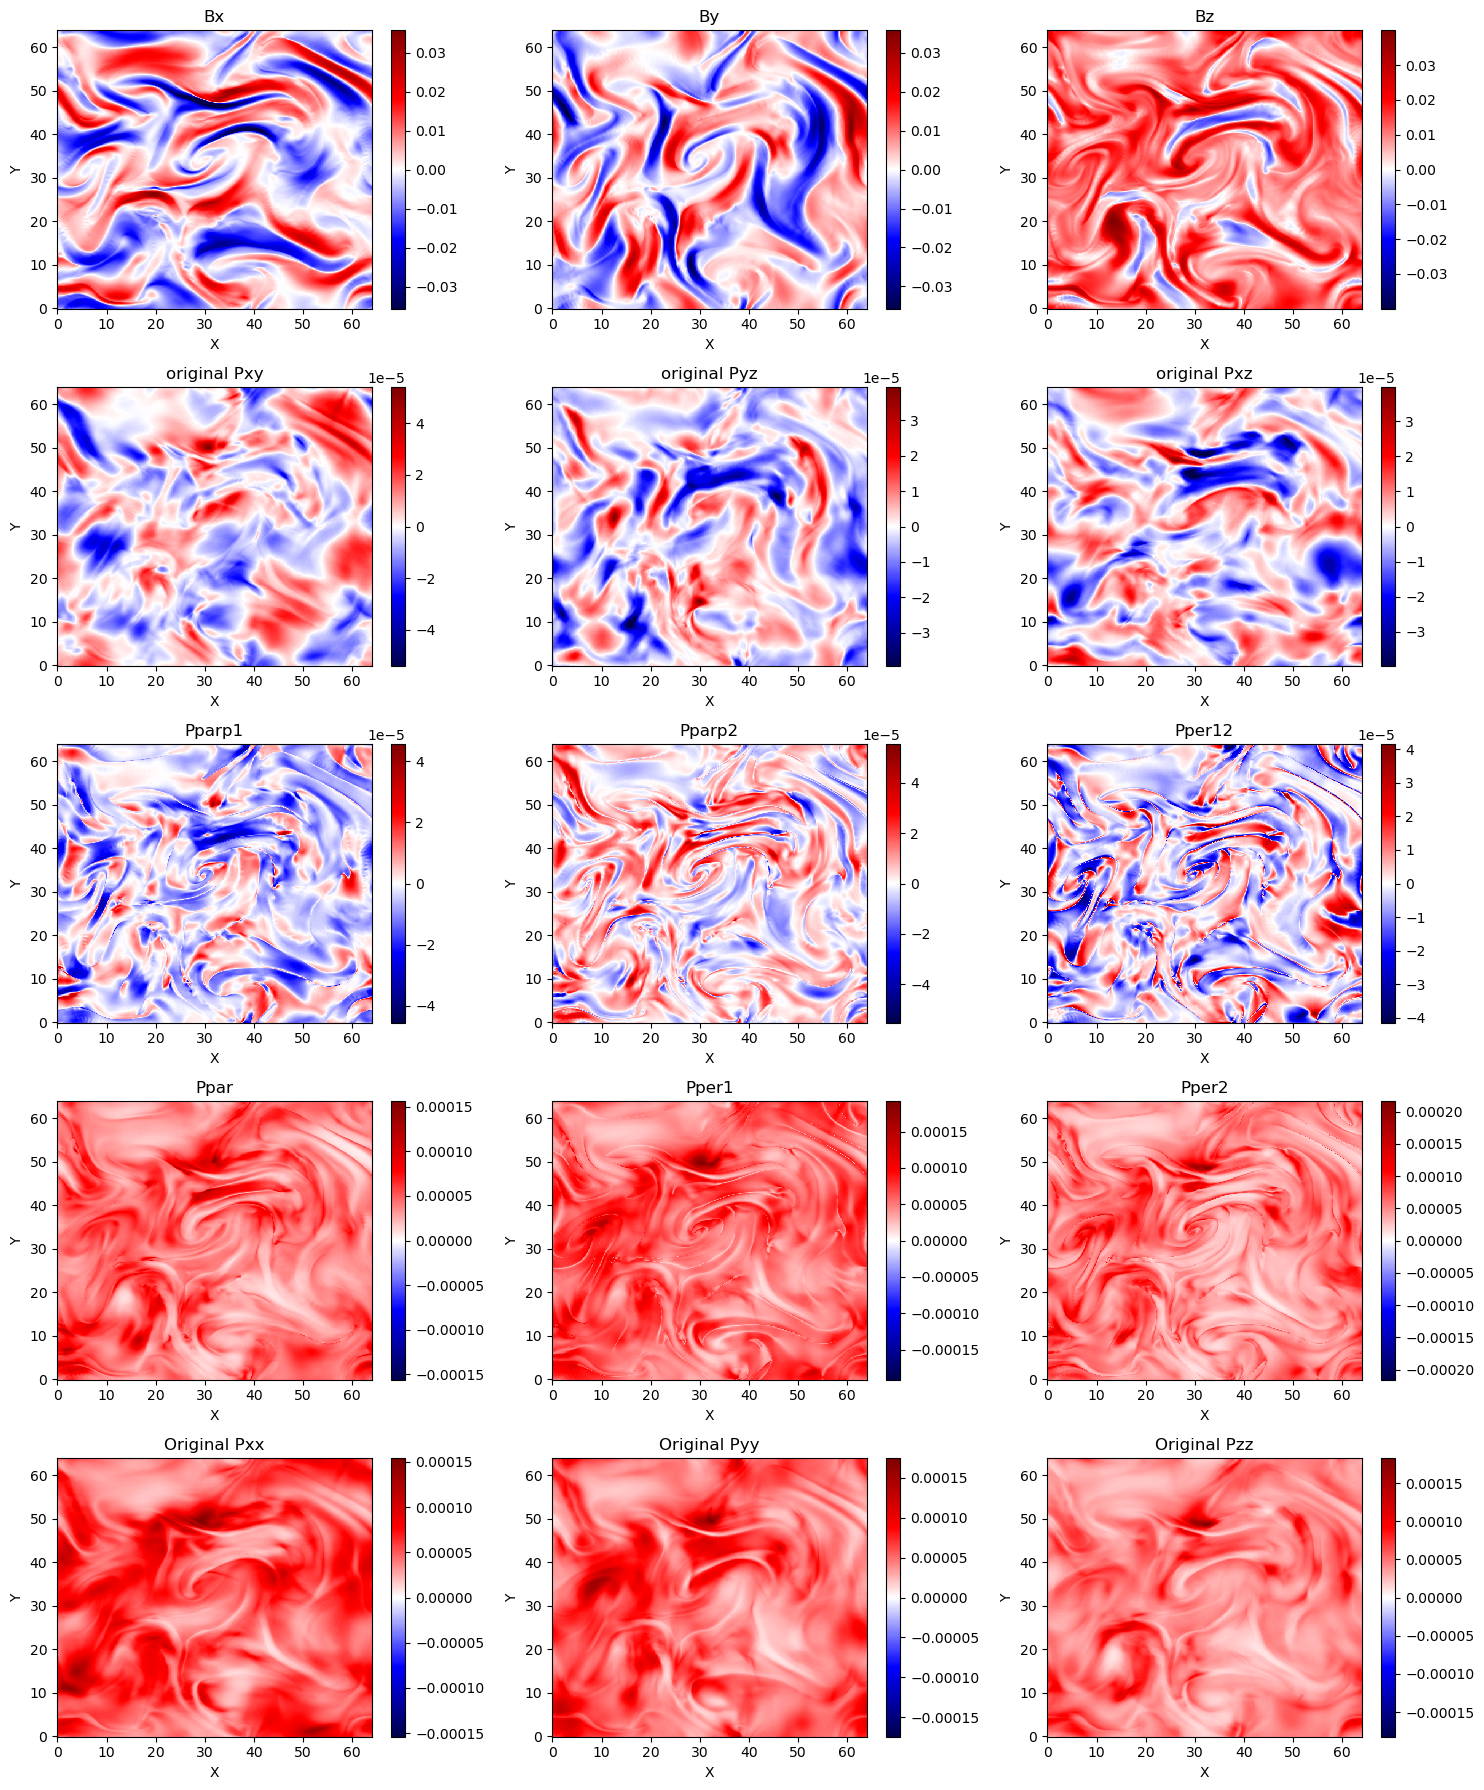

In [12]:
i = 15

Vx = data['Vx']['i'][...,i].flatten()
Vy = data['Vy']['i'][...,i].flatten()
Vz = data['Vz']['i'][...,i].flatten()
Pxx = data['Pxx']['i'][...,i].flatten()
Pxy = data['Pxy']['i'][...,i].flatten()
Pxz = data['Pxz']['i'][...,i].flatten()
Pyy = data['Pyy']['i'][...,i].flatten()
Pyz = data['Pyz']['i'][...,i].flatten()
Pzz = data['Pzz']['i'][...,i].flatten()

P_xyz = np.vstack((Pxx, Pxy, Pxz, Pxy, Pyy, Pyz, Pxz, Pyz, Pzz))
P_magn = field_aligned_trafo(Bx, By, Bz, P_xyz, matrix = True) #
data['Ppar'] = P_magn[:,0,0].reshape(data['Pxx']['i'][...,i].shape)
data['Pper1'] = P_magn[:,1,1].reshape(data['Pxx']['i'][...,i].shape)
data['Pper2'] = P_magn[:,2,2].reshape(data['Pxx']['i'][...,i].shape)
data['Pparp1'] = P_magn[:,0,1].reshape(data['Pxx']['i'][...,i].shape)
data['Pparp2'] = P_magn[:,0,2].reshape(data['Pxx']['i'][...,i].shape)
data['Pper12'] = P_magn[:,1,2].reshape(data['Pxx']['i'][...,i].shape)
Bx = data['Bx'][...,i].flatten()
By = data['By'][...,i].flatten()
Bz = data['Bz'][...,i].flatten()
Vx, Vy, Vz = transform_field(Bx, By, Bz, Vx, Vy, Vz)
data["Vxrot"] = Vx.reshape(data['Vx']['i'][...,i].shape)
data["Vyrot"] = Vy.reshape(data['Vy']['i'][...,i].shape)
data["Vzrot"] = Vz.reshape(data['Vz']['i'][...,i].shape)
fig, axs = plt.subplots(5, 3, figsize=(15, 18))
# Top panels: Bx, By, Bz
axs[0, 0].pcolormesh(X, Y, Bx.reshape(data['Bx'][...,i].shape), cmap='seismic', vmax=Bx.max(), vmin=-Bx.max())
axs[0, 0].set_title('Bx')
axs[0, 1].pcolormesh(X, Y, By.reshape(data['By'][...,i].shape), cmap='seismic', vmax=By.max(), vmin=-By.max())
axs[0, 1].set_title('By')
axs[0, 2].pcolormesh(X, Y, Bz.reshape(data['Bz'][...,i].shape), cmap='seismic', vmax=Bz.max(), vmin=-Bz.max())
axs[0, 2].set_title('Bz')

# Middle panels: Vx, Vy, Vz
axs[1, 0].pcolormesh(X, Y, data['Pxy']['i'][...,i], cmap='seismic', vmax=data['Pxy']['i'][...,i].max(), vmin=-data['Pxy']['i'][...,i].max())
axs[1, 0].set_title('original Pxy')
axs[1, 1].pcolormesh(X, Y, data['Pyz']['i'][...,i], cmap='seismic', vmax=data['Pyz']['i'][...,i].max(), vmin=-data['Pyz']['i'][...,i].max())
axs[1, 1].set_title('original Pyz')
axs[1, 2].pcolormesh(X, Y, data['Pxz']['i'][...,i], cmap='seismic', vmax=data['Pxz']['i'][...,i].max(), vmin=-data['Pxz']['i'][...,i].max())
axs[1, 2].set_title('original Pxz')


# Middle panels: Vx, Vy, Vz
axs[2, 0].pcolormesh(X, Y, data['Pparp1'], cmap='seismic', vmax=data['Pparp1'].max(), vmin=-data['Pparp1'].max())
axs[2, 0].set_title('Pparp1')
axs[2, 1].pcolormesh(X, Y, data['Pparp2'], cmap='seismic', vmax=data['Pparp2'].max(), vmin=-data['Pparp2'].max())
axs[2, 1].set_title('Pparp2')
axs[2, 2].pcolormesh(X, Y, data['Pper12'], cmap='seismic', vmax=data['Pper12'].max(), vmin=-data['Pper12'].max())
axs[2, 2].set_title('Pper12')

# Middle panels: Vx, Vy, Vz
axs[3, 0].pcolormesh(X, Y, data['Ppar'], cmap='seismic', vmax=data['Ppar'].max(), vmin=-data['Ppar'].max())
axs[3, 0].set_title('Ppar')
axs[3, 1].pcolormesh(X, Y, data['Pper1'], cmap='seismic', vmax=data['Pper1'].max(), vmin=-data['Pper1'].max())
axs[3, 1].set_title('Pper1')
axs[3, 2].pcolormesh(X, Y, data['Pper2'], cmap='seismic', vmax=data['Pper2'].max(), vmin=-data['Pper2'].max())
axs[3, 2].set_title('Pper2')

# Bottom panels: Original Vx, Vy, Vz
axs[4, 0].pcolormesh(X, Y, data['Pxx']['i'][...,i], cmap='seismic', vmax=data['Pxx']['i'][...,i].max(), vmin=-data['Pxx']['i'][...,i].max())
axs[4, 0].set_title('Original Pxx')
axs[4, 1].pcolormesh(X, Y, data['Pyy']['i'][...,i], cmap='seismic', vmax=data['Pyy']['i'][...,i].max(), vmin=-data['Pyy']['i'][...,i].max())
axs[4, 1].set_title('Original Pyy')
axs[4, 2].pcolormesh(X, Y, data['Pzz']['i'][...,i], cmap='seismic', vmax=data['Pzz']['i'][...,i].max(), vmin=-data['Pzz']['i'][...,i].max())
axs[4, 2].set_title('Original Pzz')

for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(ax.collections[0], ax=ax)

plt.tight_layout()
plt.show()
